### setup

In [110]:
import sympy as sym
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
from IPython.display import Image

### Problem 1

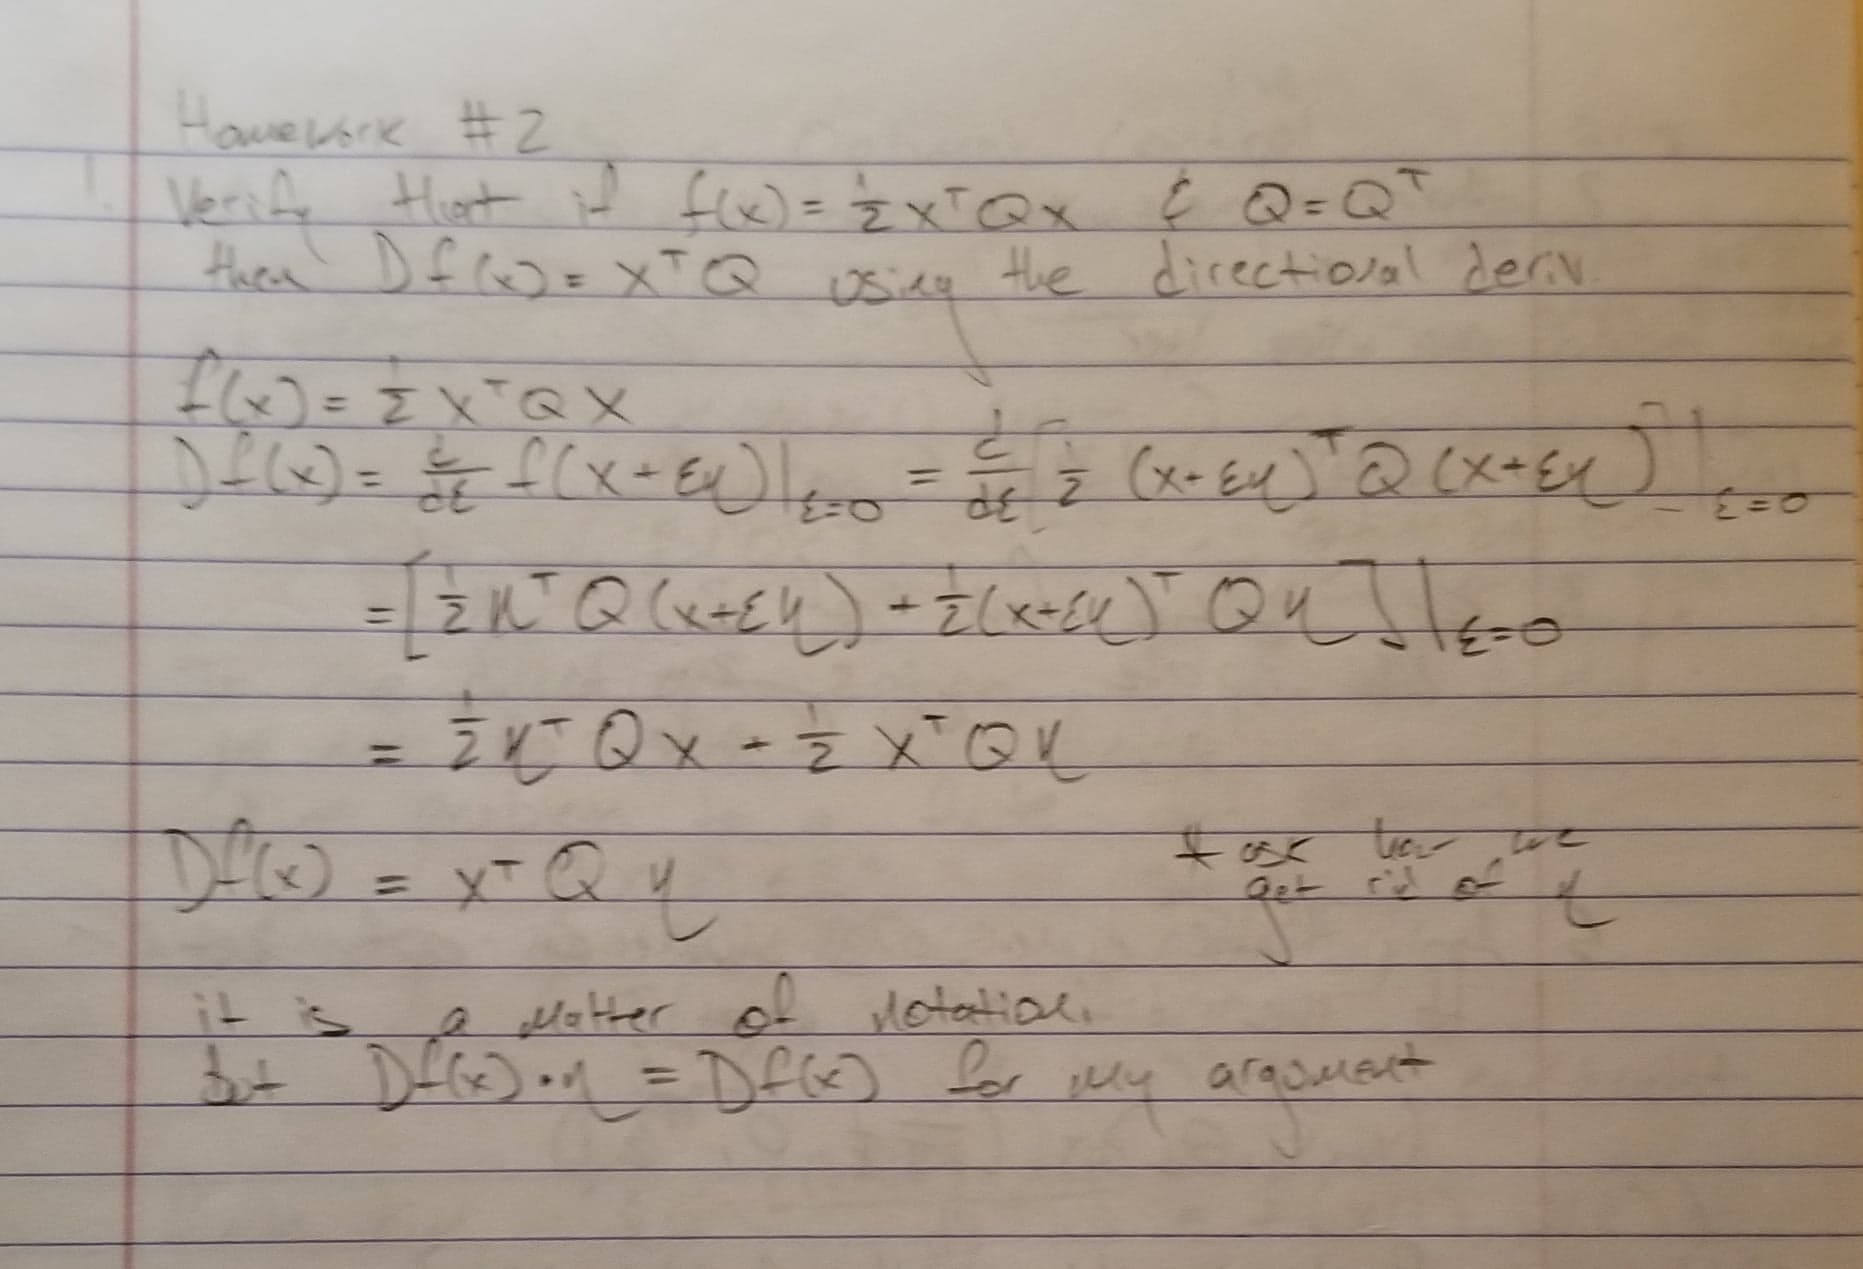

In [111]:
Image("p1.jpg")

### Problem 2

In [2]:
def x_init_gen(dim):
    x_inits = (np.zeros((dim,1)) - 10) +  np.random.rand(dim,1) * 20
    return x_inits

In [3]:
#generate random nxn diagonal matrix with elements betwen 0.5 - 1.9
def Q_gen(dim):
    I = np.identity(dim)
    rand_arr = (np.zeros((dim,1)) + 0.5) +  np.random.rand(dim,1) * 1.4
    Q = I * rand_arr
    return Q

In [4]:
#set up symbollic f and grad_f for lambda evals
n = sym.symbols('n')
x = sym.MatrixSymbol('x', n, 1)
Q = sym.MatrixSymbol('Q', n, n)
f = sym.Rational(1,2) * x.T * Q * x
grad_f = f.diff(x)
grad_2_f = grad_f.diff(x)
f_lam = sym.lambdify([x, Q], f)
grad_f_lam = sym.lambdify([x, Q], grad_f)
grad_2_f_lam = sym.lambdify([x,Q], grad_2_f)

In [5]:
#define our function that performs gradient descent on ambigiously dimensonal funcs
#creates random x and Q per descent
def ambig_dim_grad_desc(dim):
    eps = 0.1
    num_its = 0
    Q = Q_gen(dim)
    x = x_init_gen(dim)
    grad = grad_f_lam(x, Q)
    mag_grad = np.linalg.norm(grad)
    while (mag_grad > eps):
        x_next = x - grad
        grad = grad_f_lam(x_next, Q)
        mag_grad = np.linalg.norm(grad)
        x = x_next
        num_its = num_its + 1
    return num_its
    
    

In [6]:
n_vals = np.arange(1,101)
ave_it_vals = np.zeros(100)
#iterate over n = 1-100
for n in range(1,101):
    # perform 100 random inits per n and average number of its
    ave = 0
    for i in range(100):
        ave = ave + (1/100 * ambig_dim_grad_desc(n))
    # add averaged val to list
    ave_it_vals[n-1] = ave


<IPython.core.display.Javascript object>


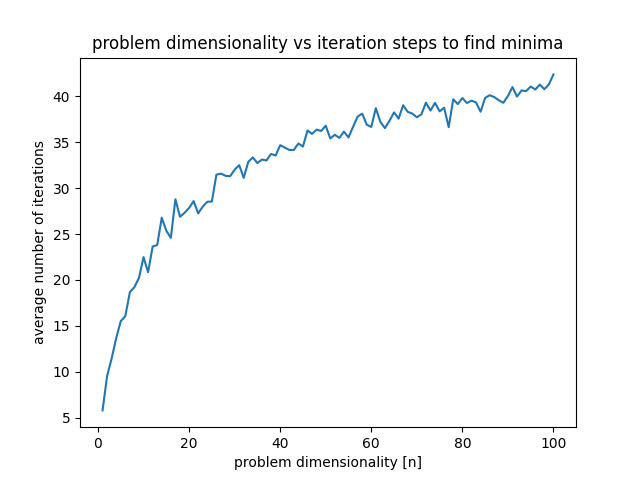

In [7]:
plt.figure()
plt.plot(n_vals, ave_it_vals)
plt.xlabel("problem dimensionality [n]")
plt.ylabel("average number of iterations")
plt.title("problem dimensionality vs iteration steps to find minima")
plt.show()

### Probelm 3

In [8]:
#define new function
x_sym, y, a, b, c, d = sym.symbols('x y a b c d')
f = sym.Matrix([(x_sym -a)**2 + (x_sym -a) * (y-b)+(y-b)**2])
x_0 = c
y_0 = d

g = sym.Matrix([x_sym, y]) - f.jacobian([x_sym,y]).jacobian([x_sym,y]).inv() * f.jacobian([x_sym,y]).T

#### Symbol

In [9]:
#Display Symbolic Equation
display(g)

Matrix([
[a],
[b]])

#### why is this type of problem useful to solve?
instead of simple gradient descent this is taking into account the curvature of the function, i.e. the second derivative as well

#### resolve problem 2 with hessian based descent

In [10]:
#define our function that performs gradient descent on ambigiously dimensonal funcs
#creates random x and Q per descent
def ambig_dim_grad_desc_3(dim):
    eps = 0.1
    num_its = 0
    Q = Q_gen(dim)
    x = x_init_gen(dim)
    grad = grad_f_lam(x, Q)
    grad_2 = grad_2_f_lam(x, Q)
    mag_grad = np.linalg.norm(grad)
    while (mag_grad > eps):
        x_next = x - np.matmul(np.linalg.inv(grad_2), grad)
        grad = grad_f_lam(x_next, Q)
        grad_2 = grad_2_f_lam(x_next, Q)
        mag_grad = np.linalg.norm(grad)
        x = x_next
        num_its = num_its + 1
    return num_its

In [11]:
x = x_init_gen(3)
Q = Q_gen(3)
grad = grad_f_lam(x, Q)
grad_2 = grad_2_f_lam(x, Q)

In [12]:
n_vals = np.arange(1,101)
ave_it_vals = np.zeros(100)
#iterate over n = 1-100
for n in range(1,101):
    # perform 100 random inits per n and average number of its
    ave = 0
    for i in range(100):
        ave = ave + (1/100 * ambig_dim_grad_desc_3(n))
    ave_it_vals[n-1] = ave

<IPython.core.display.Javascript object>


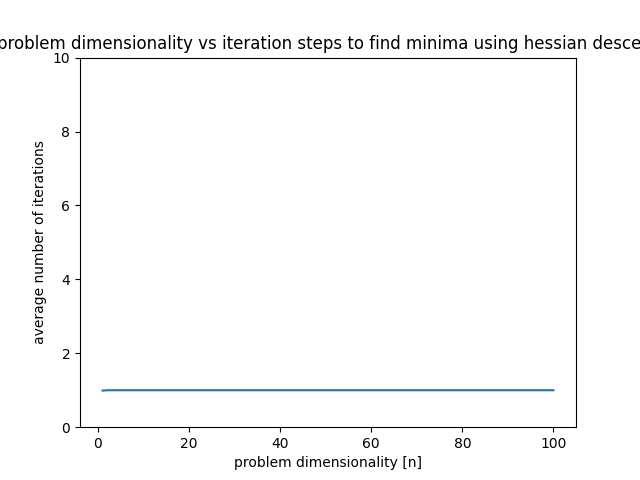

In [13]:
plt.figure()
plt.plot(n_vals, ave_it_vals)
plt.xlabel("problem dimensionality [n]")
plt.ylabel("average number of iterations")
plt.ylim([0, 10])
plt.title("problem dimensionality vs iteration steps to find minima using hessian descent")
plt.show()

#### Noting the difference:
Because the equation is quadratic, applying a quadratic fit always finds the minima within 1 iteration regardless of the dimension

### Probelm 4

In [24]:
#define symbols
theta, u1, u2, x, y  = sym.symbols('theta u_1 u_2 x y')
q = sym.Matrix([x, y, theta])
u = np.array([1, -1/2])
#get lambda eq for update
qdot = sym.lambdify([q], sym.Matrix([sym.cos(theta)*u[0], sym.sin(theta)*u[0], u[1]]))
#get init conditions and controls
q_init = np.array([0,0,np.pi/2])

T = 2 * np.pi

In [25]:
#tommy's rk4
def integrate(f,x0,dt):
    k1=dt*np.squeeze(f(x0))
    k2=dt*np.squeeze(f(x0+k1/2.))
    k3=dt*np.squeeze(f(x0+k2/2.))
    k4=dt*np.squeeze(f(x0+k3))
    xnew=x0+(1/6.)*(k1+2.*k2+2.*k3+k4)
    return xnew

In [26]:
def simulate(f,x0, tspan,dt):
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
        xtraj[:,i]=integrate(f,x,dt)
        x = np.copy(xtraj[:,i])
    return xtraj   

In [27]:
def dynamics(q):
    q_dot = qdot(q)
    return q_dot

In [28]:
tspan = [0, T]
dt = 0.1
# N = int((max(tspan)-min(tspan))/dt)
# tvec = np.linspace(min(tspan),max(tspan),N)
xvec = simulate(dynamics, q_init,tspan, dt)
# tvec = np.linspace(min(tspan),max(tspan),N)

<IPython.core.display.Javascript object>


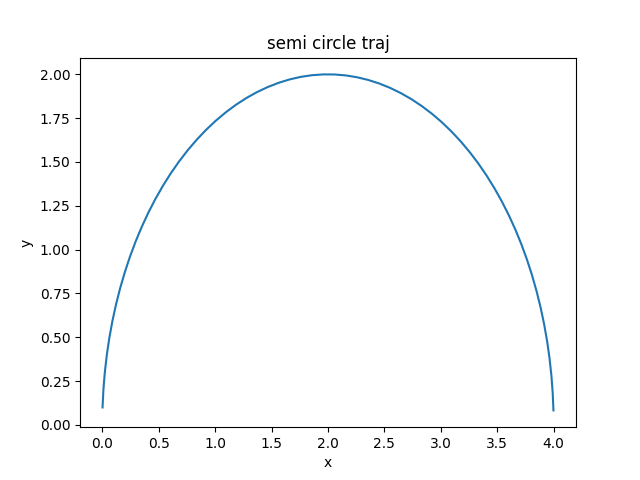

In [29]:
plt.figure()
plt.plot(xvec[0,:], xvec[1,:])
plt.title("semi circle traj")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [30]:
tspan = [0, T]
dt = 0.1
N = int((max(tspan)-min(tspan))/dt)
tvec = np.linspace(min(tspan),max(tspan),N)

## Problem 5

If desired trajectory is: $(x_d, y_d, \theta_d) = (\frac{4}{2\pi}, 0, \frac{\pi}{2})$ How is the movement constrained?

The movement is constrained from 3 dimensions to 1.

In [96]:
from scipy.optimize import minimize
tspan = [0, T]
dt = 0.1
N = int((max(tspan)-min(tspan))/dt)
#symbolic objective function
Q = sym.Matrix([[1, 0, 0],[0,.1,0],[0, 0, .01]]) 
R = sym.Matrix([[1, 0],[0,.1]]) #u1 matters more than u2
P = sym.Matrix([[10000, 0, 0], [0, 1000, 0], [0, 0, 10]])
#these will be replaced with actual xi and ui vals per it
x, y, theta, u1, u2, t = sym.symbols('x y theta u_1 u_2 t')
x_sym = sym.Matrix([x, y, theta])
u_sym = sym.Matrix([u1, u2])
x_d = sym.Matrix([4/(2*sym.pi) *t, 0, sym.pi/2])

x_0 = np.array([0,0,np.pi/2])
del_x = x_sym - x_d
#construct l
l = sym.Rational(1,2) * del_x.T * Q * del_x + sym.Rational(1,2) * u_sym.T * R * u_sym
l = sym.lambdify([x_sym, u_sym, t], l)
#construct m
m = sym.Rational(1,2) * del_x.T * P * del_x
m = sym.lambdify([x_sym, t], m)
#construct f, our update function given above as qdot
f = sym.lambdify([x_sym, u_sym], sym.Matrix([sym.cos(theta)*u1, sym.sin(theta)*u1, u2]))

#define our discretized cost function
def h(xu):
    x_sym = xu.reshape(5,N)[:3, :]
    u_sym = xu.reshape(5,N)[3:,:]
    val = 0
    #perform discrete integration
    for i in range(N):
        val = val + l(np.expand_dims(x_sym[:,i],1), np.expand_dims(u_sym[:,i],1), i)
    val = val + m(np.expand_dims(x_sym[:,-1],1), N)
    return val

#return a list of all constraints
def g(xu):
#     xu = xu.reshape(5, N)
    constraints = np.empty(3 * N)
    #first constraint is x0
    constraints[0] = xu[0] - x_0[0]
    constraints[N] = xu[N] - x_0[1]
    constraints[2*N] = xu[2*N] - x_0[2]
    #TODO: unflatten to use matrix math to make sexier
    for i in range(1,N):
        #get state at i-1
        x_prev = np.array([xu[i-1], xu[i + N - 1], xu[i + 2*N - 1]])
        #get controls
        conrtols = np.array([xu[i+3*N], xu[i+4*N]])
        #get update
        update = f(x_prev,conrtols)
        #constraint equation from lecture 3
        for itr in range(3):
            constraints[i + itr * N] = xu[i + itr * N] - x_prev[itr] - dt * update[itr]
    return constraints


# make sure inputs vectors of form: np.array([[el,el,el]]).T


In [97]:
#flatten x to: x, y, theta and append u 
xvec.shape
uvec = np.zeros((u.shape[0], N)) + np.expand_dims(u,1)

In [98]:
print(xvec.shape)
print(uvec.shape)

(3, 62)
(2, 62)


In [99]:
xu = np.concatenate((xvec,uvec))
print(xu.shape)

(5, 62)


In [100]:

my_cons = {'type':'eq', 'fun':g}


In [101]:
xu.flatten().shape

(310,)

In [102]:
my_min = minimize(h, xu.flatten(), constraints=my_cons)

In [104]:
soln = my_min.x.reshape(5,N)

<IPython.core.display.Javascript object>


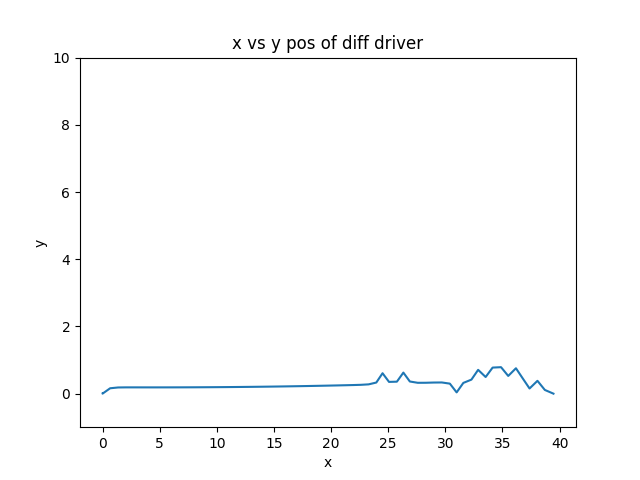

In [116]:
plt.figure()
plt.plot(soln[0,:], soln[1,:])
plt.ylim([-1, 10])
plt.xlabel("x")
plt.ylabel("y")
plt.title("x vs y pos of diff driver")
plt.show()

<IPython.core.display.Javascript object>


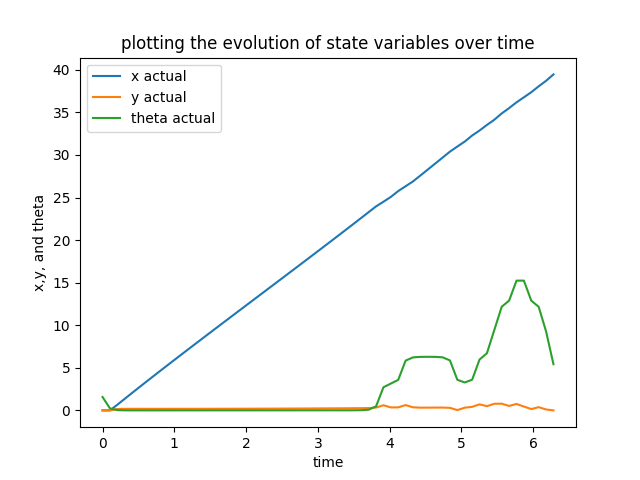

In [113]:
plt.figure()
plt.plot(tvec, soln[0,:])
plt.plot(tvec, soln[1,:])
plt.plot(tvec, soln[2,:])

plt.xlabel("time")
plt.ylabel("x,y, and theta")
plt.legend(["x actual", "y actual", "theta actual"])
plt.title("plotting the evolution of state variables over time")
plt.show()

#### note

while this is far from perfect, the infrastructure is sound and just requires tuning of the P, R, and Q parameters